In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils


In [10]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange

from utilsLoaders import read_trc, read_mot
from utils import center_of_mass

from numpy.linalg import norm

datadir = Path('./datadir')

def get_trc_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'MarkerData/PostAugmentation/{trial}/{trial}.trc'

def get_mot_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'OpenSimData/Kinematics/{trial}.mot'
    
def get_model_fpath(sid):
    return datadir / f'opencap_data/{sid}/' \
        f'OpenSimData/Model/LaiUhlrich2022_scaled.osim'


In [5]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72


In [7]:
df_session = pd.read_excel(datadir / 'session_info.xlsx', )
df_trial = pd.read_excel(datadir / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / 'participant_info.xlsx')


/Users/psr/opt/anaconda3/envs/opensim/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


p060


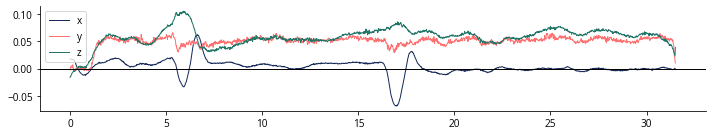

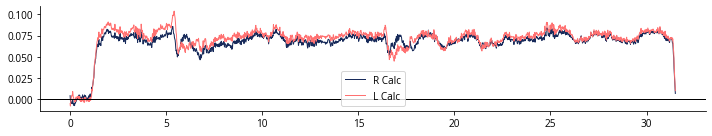

In [11]:
from numpy.linalg import norm

pid = 'p014'
pid = 'p060'
# pid = 'p093'
# pid = 'p030' # soleus > gastroc

df_temp = df_trial[df_trial.trial_clean == 'toe_stand']
df_temp = df_temp[df_temp.pid == pid]
um = df_temp.sample(1).iloc[0]
pid, sid, trial = um[['pid', 'sid', 'trial']]
print(pid)

fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
com = center_of_mass(get_model_fpath(sid), get_mot_fpath(sid, trial))

start_win = int(fps*1)
com_start = com[:start_win,:].mean(0)
com -= com_start

rc = xyz[:,np.argmax(markers=='r_calc_study'),:]
lc = xyz[:,np.argmax(markers=='L_calc_study'),:]

rc -= rc[:start_win,:].mean(0)
lc -= lc[:start_win,:].mean(0)


t = np.arange(xyz.shape[0]) / fps

plt.figure(figsize=(10,2))
plt.plot(t, com[:,0], lw=1, label='x')
plt.plot(t, com[:,1], lw=1, label='y')
plt.plot(t, com[:,2], lw=1, label='z')
plt.axhline(0, c='k', lw=1)
# plt.plot(com[:,1])
# plt.plot(conv)
# plt.axvline(offset, c=cp[3], lw=1)
# plt.axvline(offset + win_size, c=cp[3], lw=1)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,2))
plt.plot(t, rc[:,1], lw=1, label='R Calc')
plt.plot(t, lc[:,1], lw=1, label='L Calc')
plt.axhline(0, c='k', lw=1)
# plt.plot(com[:,1])
# plt.plot(conv)
# plt.axvline(offset, c=cp[3], lw=1)
# plt.axvline(offset + win_size, c=cp[3], lw=1)
plt.legend()
plt.tight_layout()
plt.show()


  0%|          | 0/140 [00:00<?, ?it/s]

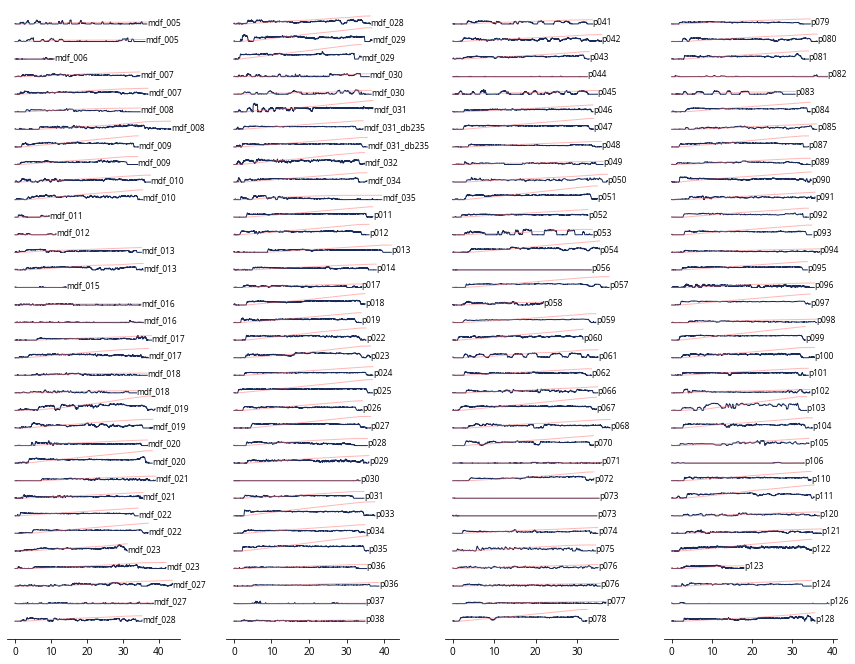

In [45]:
df = df_trial[df_trial.trial_clean=='toe_stand']
n = len(df)

ncols = 4

plt.figure(figsize=(3*ncols,n/15))

for i in trange(n, leave=False):
    row = df.iloc[i]
    pid, sid, trial = row.pid, row.sid, row.trial
    
    # if pid.startswith('mdf'):
    #     continue
    # if i % 3 != 0:
    #     continue
    
    # model_fpath = get_model_fpath(sid)
    # com_xyz = center_of_mass(get_model_fpath(sid),
    #                          get_mot_fpath(sid, trial))
    # h = com_xyz[:,1]

    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

    rh = xyz[:,np.argmax(markers=='RHJC_study'),:].copy()
    lh = xyz[:,np.argmax(markers=='LHJC_study'),:].copy()
    com = (rh + lh) / 2
    
    start_win = int(fps*1)
    com_start = com[:start_win,:].mean(0)
    com -= com_start
    
    h = com[:,1]
    h = np.clip(h, 0, None)
    h *= 0.5
    
    dt = 1/fps
    hsum = np.cumsum(h) * dt
    
    t = np.arange(h.size) / fps

    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t, h*10-i%(n/ncols)*1.5, lw=1, c=cp[0], zorder=-1, alpha=1)
    plt.plot(t, hsum-i%(n/ncols)*1.5, lw=1, c=cp[1], zorder=-1, alpha=0.5)
    # for k, (rl, ll) in enumerate(half_cycles):
    #     plt.plot(t[rl:ll], h[rl:ll]-i%(n/ncols)*1.5, lw=1, c=cp[k%len(cp)], zorder=1)
    plt.text(t[-1], 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)
    
    # if i > 10:
    #     break

sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_toe_stand.pdf')
plt.show()


p014


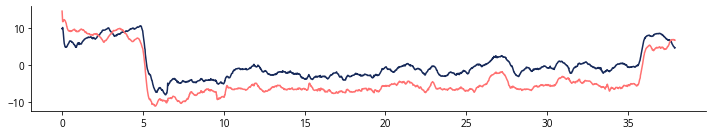

In [6]:
from numpy.linalg import norm

pid = 'p014'
# pid = 'p030'
# pid = 'p060'
# pid = 'p093'
# pid = 'p043'

df_temp = df_trial[df_trial.trial_clean == 'toe_stand']
df_temp = df_temp[df_temp.pid == pid]
um = df_temp.sample(1).iloc[0]
pid, sid, trial = um[['pid', 'sid', 'trial']]
print(pid)

df = read_mot(get_mot_fpath(sid, trial))
ra = df['ankle_angle_r'].values
la = df['ankle_angle_l'].values
t = df['time'].values

plt.figure(figsize=(10,2))
plt.plot(t, ra)
plt.plot(t, la)
plt.tight_layout()
plt.show()

# t = np.arange(xyz.shape[0]) / fps
# plt.figure(figsize=(10,2))
# plt.plot(t[1:], np.diff(com[:,1]))
# plt.tight_layout()
# plt.show()


In [7]:
df_temp = df_trial[df_trial.trial_clean == 'jump']
data = []
for i, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
    pid, sid, trial = row[['pid', 'sid', 'trial']]
    
    df = read_mot(get_mot_fpath(sid, trial))
    raa = df['ankle_angle_r'].values
    laa = df['ankle_angle_l'].values
    t = df['time'].values
    
    int_raa = np.sum(raa) / fps
    int_laa = np.sum(laa) / fps
    mean_int_aa = (int_raa + int_laa) / 2

    data.append({'pid': pid,
                 'mean_int_aa': mean_int_aa,
                })


  0%|          | 0/88 [00:00<?, ?it/s]

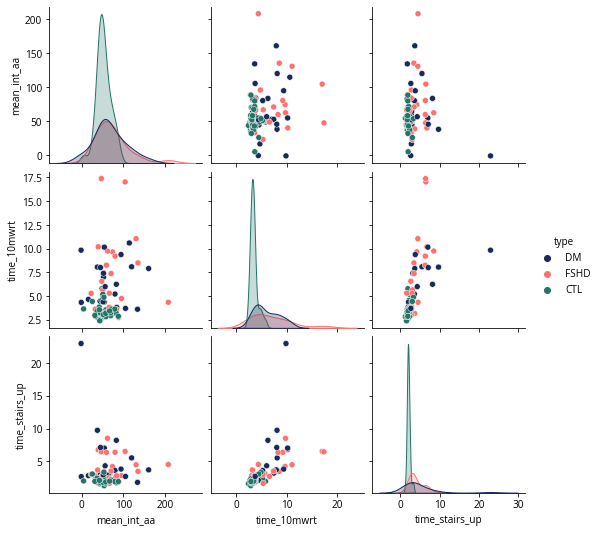

In [8]:
df_toe_stand = pd.DataFrame(data)
df_temp = df_toe_stand.merge(df_part[['pid', 'time_10mwrt', 'time_stairs_up', 'type']],
                             on='pid', how='left')

sns.pairplot(df_temp, hue='type')
plt.show()


In [9]:
df_temp = df_trial[df_trial.trial_clean == 'jump']
data = []
for i, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
    pid, sid, trial = row[['pid', 'sid', 'trial']]
    
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
    com = ocfeats.center_of_mass(get_model_fpath(sid), get_mot_fpath(sid, trial))

    start_win = int(fps*1)
    com_start = com[:start_win,:].mean(0)
    com -= com_start
    com_height = com_start[1]

    rc = xyz[:,np.argmax(markers=='r_calc_study'),:]
    lc = xyz[:,np.argmax(markers=='L_calc_study'),:]
    rc -= rc[:start_win,:].mean(0)
    lc -= lc[:start_win,:].mean(0)
    
    int_com_elev = np.sum(com[:,1]) / com_height
    int_com_fwd = np.sum(com[:,2]) / com_height
    # int_r_heel_elev = np.sum(rc[:,1])
    # int_l_heel_elev = np.sum(lc[:,1])
    int_mean_heel_elev = np.sum((rc[:,1] + lc[:,1])/2) / com_height

    data.append({'pid': pid,
                 'int_com_elev': int_com_elev,
                 'int_com_fwd': int_com_fwd,
                 'int_r_heel_elev': int_r_heel_elev,
                 'int_l_heel_elev': int_l_heel_elev,
                 'int_mean_heel_elev': int_mean_heel_elev,
                })


  0%|          | 0/88 [00:00<?, ?it/s]

NameError: name 'int_r_heel_elev' is not defined

In [ ]:
new_feats = pd.DataFrame(data)
# df_toe_stand.drop(columns=new_feats.columns[1:], inplace=True)
# df_toe_stand = df_toe_stand.merge(new_feats, on='pid')

df_temp = new_feats.merge(df_part[['pid', 'time_10mwrt', 'time_stairs_up', 'type']],
                          on='pid', how='left')

feats = ['int_com_elev', 'int_com_fwd', 'int_mean_heel_elev']
sns.pairplot(df_temp, vars=feats,
             hue='type')
plt.show()



In [ ]:
new_feats = pd.DataFrame(data)
# df_toe_stand.drop(columns=new_feats.columns[1:], inplace=True)
# df_toe_stand = df_toe_stand.merge(new_feats, on='pid')

df_temp = new_feats.merge(df_part[['pid', 'time_10mwrt', 'time_stairs_up', 'type']],
                          on='pid', how='left')

feats = ['int_com_elev', 'int_com_fwd', 'int_mean_heel_elev']
sns.pairplot(df_temp, vars=feats,
             hue='type')
plt.show()



In [ ]:
# df_toe_stand = pd.DataFrame(data)
# df_temp = df_toe_stand.merge(df_part[['pid', 'time_10mwrt', 'time_stairs_up', 'type']],
#                              on='pid', how='left')

# sns.pairplot(df_temp, hue='type')
# plt.show()
